Bicyclee Inventory: Infinite Capacity

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

from dataclasses import dataclass
import itertools
import numpy as np
from typing import Iterator
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd

from rl.distributions import SampledDistribution, Constant
from rl.markov_decision_process import MarkovDecisionProcess
from rl.markov_process import State, NonTerminal, TransitionStep
from rl.policy import Policy, DeterministicPolicy

In [2]:
@dataclass(frozen=True)
class Inventory:
    on_hand: int
    on_order: int
    demand: int = 0

    @property
    def total_inventory(self) -> int:
        return self.on_hand + self.on_order


@dataclass(frozen=True)
class InfiniteCapacityInventoryMDP(MarkovDecisionProcess[Inventory, int]):
    poisson_lambda: float
    holding_cost: float
    stockout_cost: float

    def step(
        self,
        state: NonTerminal[Inventory],
        action: int,
    ) -> SampledDistribution[tuple[State[Inventory], float]]:
        def sample_next_state_reward(
            state: NonTerminal[Inventory] = state,
            order: int = action,
        ) -> tuple[State[Inventory], float]:
            customer_demand: int = np.random.poisson(self.poisson_lambda)
            total_inventory: int = state.state.total_inventory

            next_state = Inventory(
                on_hand=max(total_inventory - customer_demand, 0),
                on_order=order,
                demand=customer_demand,
            )

            reward: float = (
                -self.holding_cost * state.state.on_hand
                - self.stockout_cost * max(customer_demand - total_inventory, 0)
            )

            return NonTerminal(next_state), reward

        return SampledDistribution(sample_next_state_reward)

    def actions(self, state: NonTerminal[Inventory]) -> Iterator[int]:
        return itertools.count(start=0, step=1)

    def calculate_fraction_of_days_out_of_stock(
        self,
        policy: Policy[Inventory, int],
        time_steps: int,
        num_traces: int,
    ) -> float:
        mrp = self.apply_policy(policy=policy)
        count = 0
        high_fractile = int(ss.poisson(self.poisson_lambda).ppf(0.98))
        start_state = np.random.choice(
            [Inventory(on_hand=i, on_order=0) for i in range(high_fractile + 1)]
        )

        for _ in range(num_traces):
            for step in itertools.islice(
                mrp.simulate_reward(
                    start_state_distribution=Constant(NonTerminal(start_state))
                ),
                time_steps,
            ):
                # if store experiences stockout cost, increment count
                if step.reward < -self.holding_cost * step.state.state.on_hand:
                    count += 1

        return float(count) / (time_steps * num_traces)

    def generate_traces(
        self,
        policy: Policy[Inventory, int],
        time_steps: int,
        num_traces: int,
    ) -> list[list[TransitionStep[Inventory]]]:
        mrp = self.apply_policy(policy=policy)
        start_state = Inventory(on_hand=0, on_order=0)

        traces = [
            [
                (s.state.state, s.next_state.state, s.reward)
                for s in itertools.islice(
                    mrp.simulate_reward(
                        start_state_distribution=Constant(NonTerminal(start_state))
                    ),
                    time_steps,
                )
            ]
            for _ in range(num_traces)
        ]

        return traces

In [3]:
HOLDING_COST = 10.0
STOCKOUT_COST = 200.0

infinite_cap_mdp = InfiniteCapacityInventoryMDP(
    poisson_lambda=50.0,
    holding_cost=HOLDING_COST,
    stockout_cost=STOCKOUT_COST,
)

In [44]:
class InventoryStochasticPolicy(Policy[Inventory, int]):
    reorder_point_poisson_mean: float

    def __init__(self, reorder_point_poisson_mean: float):
        self.reorder_point_poisson_mean = reorder_point_poisson_mean

    def act(self, state: NonTerminal[Inventory]) -> SampledDistribution[int]:
        def action_func(state: NonTerminal[Inventory] = state) -> int:
            # let's model the reorder point as a Poisson random variable
            sampled_reorder_point = np.random.poisson(self.reorder_point_poisson_mean)
            return 10 + max(sampled_reorder_point - state.state.total_inventory, 0)

        return SampledDistribution(sampler=action_func)


class InventoryDeterministicPolicy(DeterministicPolicy[Inventory, int]):
    def __init__(self, reorder_point: int) -> None:
        self.reorder_point: int = reorder_point

        def action_for(state: Inventory) -> int:
            return max(self.reorder_point - state.total_inventory, 0)

        super().__init__(action_for=action_for)

In [45]:
traces = infinite_cap_mdp.generate_traces(
    # policy=InventoryDeterministicPolicy(55),
    policy=InventoryStochasticPolicy(reorder_point_poisson_mean=80.0),
    time_steps=10,
    num_traces=1000,
)

In [46]:
outcomes = pd.DataFrame(
    {
        "time": [i for t in traces for i in range(1, len(t) + 1)],
        "On Hand": [s.on_hand for trace in traces for s, _, _ in trace],
        "On Order": [s.on_order for trace in traces for s, _, _ in trace],
        "Demand": [s.demand for trace in traces for s, _, _ in trace],
    }
)

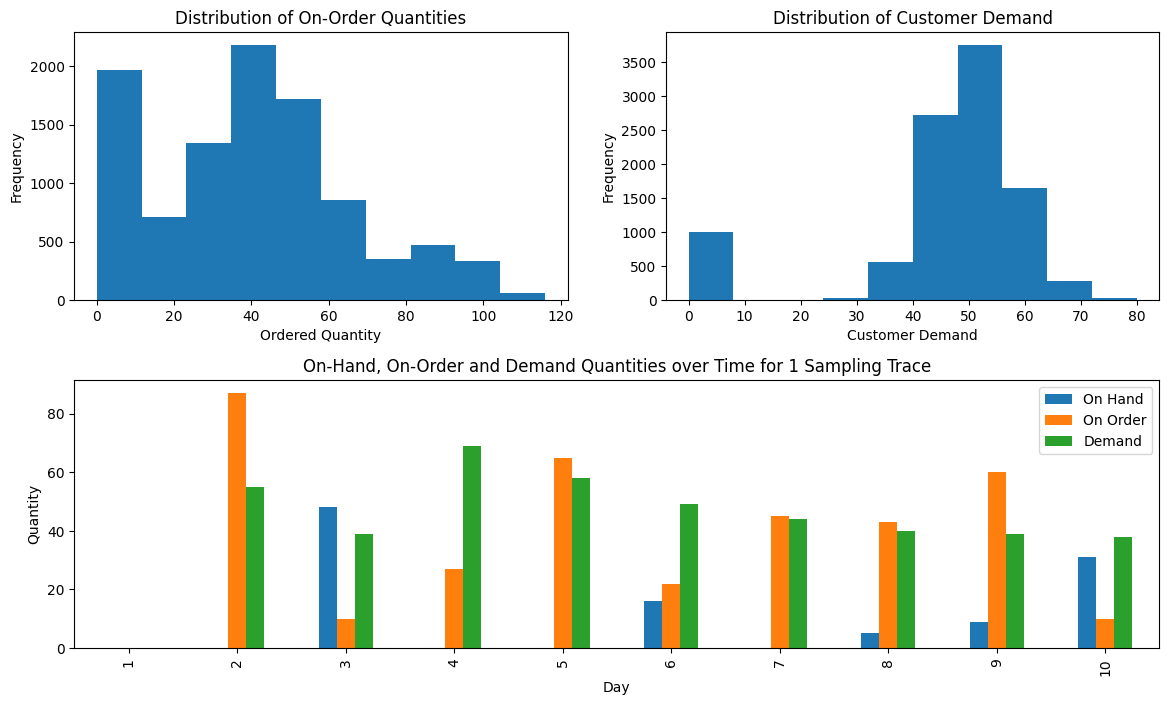

In [47]:
fig = plt.figure(figsize=(14, 8))

gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[2, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.hist(outcomes["On Order"])
ax1.set_title("Distribution of On-Order Quantities")
ax1.set_xlabel("Ordered Quantity")
ax1.set_ylabel("Frequency")

ax2.hist(outcomes["Demand"])
ax2.set_title("Distribution of Customer Demand")
ax2.set_xlabel("Customer Demand")
ax2.set_ylabel("Frequency")

outcomes.iloc[:10].groupby(by="time", as_index=False).mean().plot(
    kind="bar",
    ax=ax3,
    x="time",
    y=["On Hand", "On Order", "Demand"],
)
ax3.set_title("On-Hand, On-Order and Demand Quantities over Time for 1 Sampling Trace")
ax3.set_xlabel("Day")
ax3.set_ylabel("Quantity")

plt.show()